In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

query = '''
SELECT * FROM modelling_view
WHERE Date_time BETWEEN '2020-01-01 00:00:00' AND '2022-01-01 00:00:00';
'''
modelling_view = pd.read_sql(query, db_connection)

C:\Users\PC\AppData\Local\Temp\ipykernel_16084\1733514582.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  modelling_view = pd.read_sql(query, db_connection)


In [2]:
#create two groups for main_duty and borough based on the average max_tactic used in each group
#cut in performed at the median

avg_max_tactic_m = modelling_view.groupby('main_duty')['max_tactic'].mean()
main_duty_bins = pd.qcut(avg_max_tactic_m.values, q=2)
duty_to_group = {duty: int(group) for duty, group in zip(avg_max_tactic_m.index, main_duty_bins.codes)}
modelling_view['main_duty_group'] = modelling_view['main_duty'].map(duty_to_group)
print(modelling_view['main_duty_group'].value_counts())

avg_max_tactic_b = modelling_view.groupby('borough')['max_tactic'].mean()
main_borough_bins = pd.qcut(avg_max_tactic_b.values, q=2)
borough_to_group = {borough: int(group) for borough, group in zip(avg_max_tactic_b.index, main_borough_bins.codes)}
modelling_view['borough_group'] = modelling_view['borough'].map(borough_to_group)
print(modelling_view['borough_group'].value_counts())

0    276035
1     17805
Name: main_duty_group, dtype: int64
1    148934
0    144906
Name: borough_group, dtype: int64


In [3]:
#display the distribution of a target variable
print(modelling_view['primary_conduct'].value_counts())
#randomly shuffle the data
modelling_view = modelling_view.sample(frac=1, random_state=1)

#perform the binning of the data to get 3 classes of primary conduct
modelling_view['primary_conduct_mcl'] = modelling_view['primary_conduct'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else 2))
print(modelling_view['primary_conduct_mcl'].value_counts())

0    131470
3     51969
2     41890
4     32385
1     27032
5      9094
Name: primary_conduct, dtype: int64
0    131470
2     93448
1     68922
Name: primary_conduct_mcl, dtype: int64


In [4]:
#perform undersampling of the test data to balance the classes

#separate the classes
class_0 = modelling_view[modelling_view['primary_conduct_mcl'] == 0]
class_1 = modelling_view[modelling_view['primary_conduct_mcl'] == 1]
class_2 = modelling_view[modelling_view['primary_conduct_mcl'] == 2]

#determine the number of samples in the smallest class
n_samples = min(len(class_0), len(class_1), len(class_2))

#sample all the classes to the number of samples in the smallest class
class_0_under = class_0.sample(n_samples, random_state=1)
class_1_under = class_1.sample(n_samples, random_state=1)
class_2_under = class_2.sample(n_samples, random_state=1)

#concatenate the classes into a dataframe
df_under = pd.concat([class_0_under, class_1_under, class_2_under], axis=0)

#check the number of samples in each class
print(df_under['primary_conduct_mcl'].value_counts())

0    68922
1    68922
2    68922
Name: primary_conduct_mcl, dtype: int64


In [5]:
#separate the training data into X and y (predictors and response)
#while dropping the irrelavant predictors
X_train = df_under.drop(['date_time', 'main_duty', 'borough', 
                        'non_compliant', 'physical_force_applied', 'max_tactic',
                        'year', 'primary_conduct', 'primary_conduct_mcl'], axis=1)
y_train = df_under['primary_conduct_mcl']

In [6]:
#import the libraries necessary for XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [10]:
#perform the grid search to determine the set of optimal hyperparameters for this data

#define the XGB classifier object with the GPU acceleration support
gb_model = xgb.XGBClassifier(tree_method='gpu_hist')
#define the grid of hyperparameters for gridsearch
gb_param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [250],
    'max_depth': [3, 5, 7, 9, 10]
}
#perform the grid search using stratified 10-fold cross-validation
gb_grid_search = GridSearchCV(gb_model,
                              param_grid=gb_param_grid,
                              cv=StratifiedKFold(n_splits=10),
                              scoring='accuracy',
                              n_jobs=-1).fit(X_train, y_train)
#extract the best set of parameters and the corresponding accuracy score
print("Best hyperparameters:", gb_grid_search.best_params_)
print("Accuracy:", gb_grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 250}
Accuracy: 0.49439945979119476


In [8]:
#retrieve the best hyperparameters obtained from the grid search
# gb_best_params = gb_grid_search.best_params_
gb_best_params = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 250}
#create a xgboost classifier passing the hyperparameters
gb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    learning_rate=gb_best_params['learning_rate'],
    n_estimators=gb_best_params['n_estimators'],
    max_depth=gb_best_params['max_depth'],
    n_jobs=-1,
)
#fit the xgboost classifier using training data
gb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

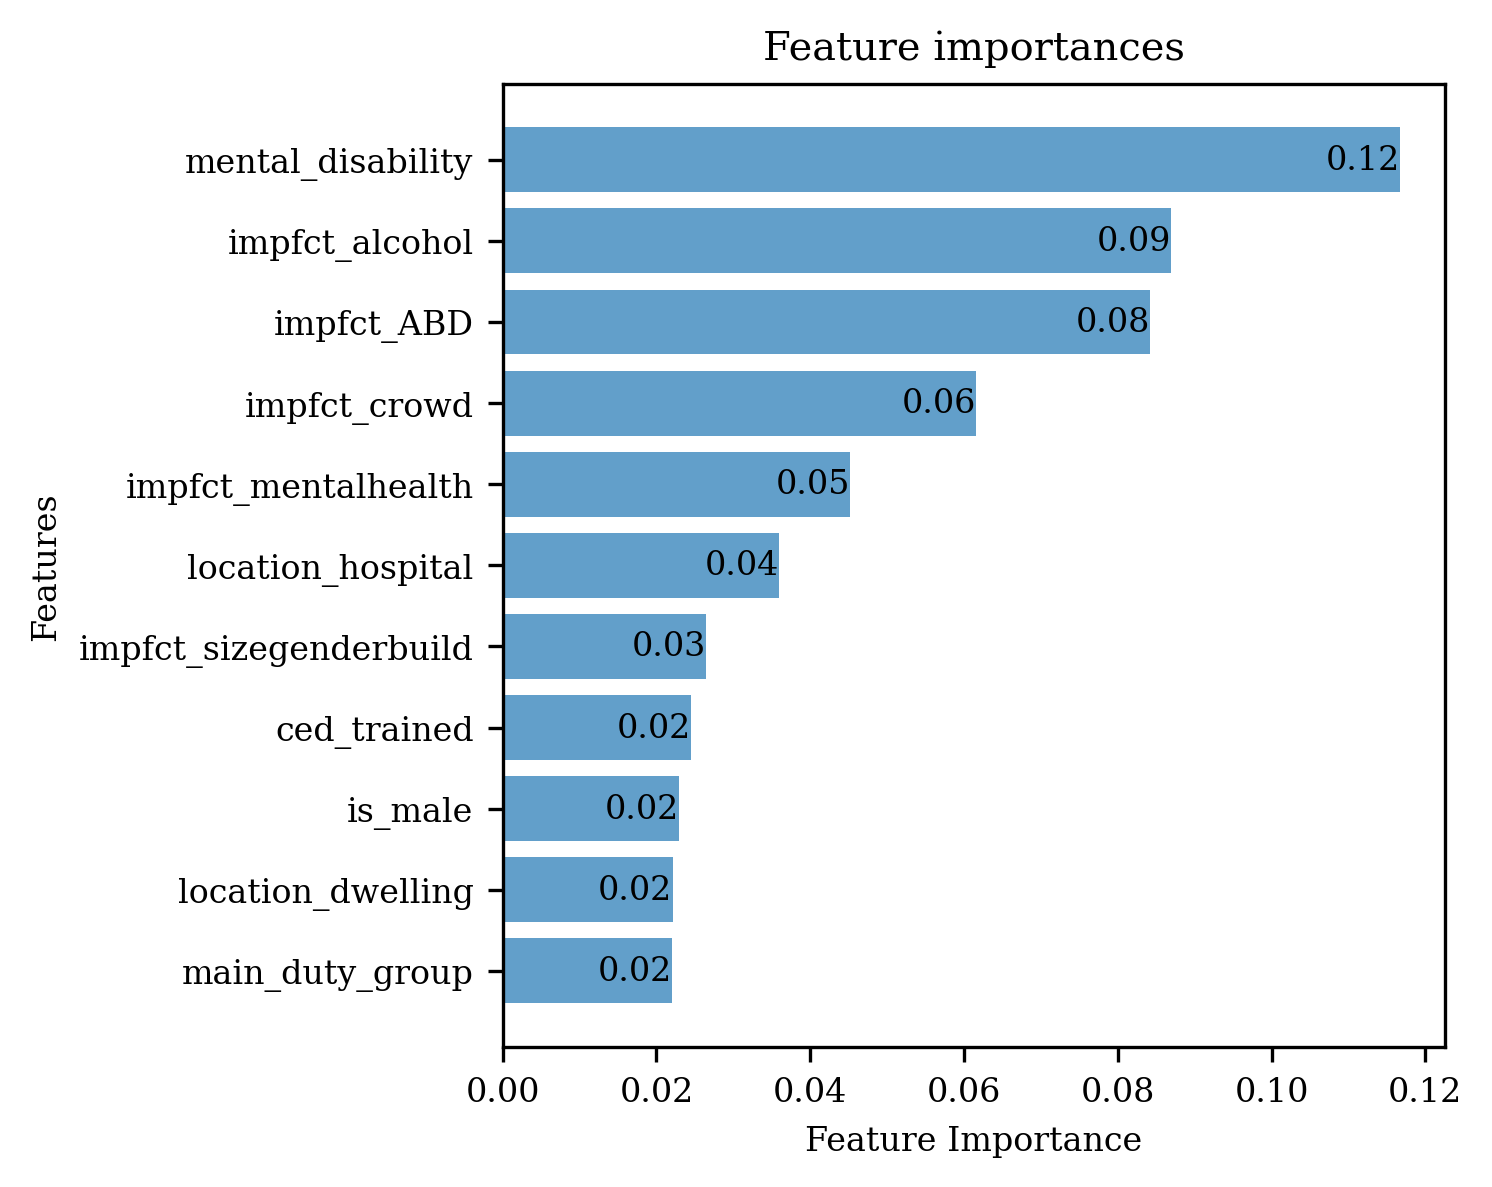

In [9]:
#extract and visualise the feature importances from the fitted model

#extract importance values and feature names
feature_importances = gb_model.feature_importances_
feature_names = X_train.columns.tolist()
#filter out the importances that account for less than 2% of the total importance
filtered_indices = np.where(np.abs(feature_importances) >= 0.02)[0]
filtered_importances = feature_importances[filtered_indices]
filtered_feature_names = np.array(feature_names)[filtered_indices]
#sort the importances and feature names
sorted_indices = np.argsort(filtered_importances)
sorted_importances = filtered_importances[sorted_indices]
sorted_feature_names = filtered_feature_names[sorted_indices]
#positions of the bars on the y-axis
y_pos = np.arange(len(sorted_feature_names))
#define the font size and family
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 8
#plot the horizontal bar chart with feature importances
plt.figure(figsize=(5, 4), dpi=300)
bars = plt.barh(y_pos, sorted_importances, align='center', alpha=0.7)
#add the labels with values to
for bar in bars:
    #get the width of the bar
    width = bar.get_width()
    #display the value next to the bar
    plt.text(width, bar.get_y() + bar.get_height()/2, f"{width:.2f}", 
             ha='left' if width < 0 else 'right', va='center', color='black')
#add the feature names to the y axis
plt.yticks(y_pos, sorted_feature_names)
#add the title and axis labels
plt.ylabel('Features')
plt.xlabel('Feature Importance')
plt.title('Feature importances')
plt.tight_layout()
#save the plot to a file and display it
plt.savefig('feature_importances_xgboost.png', dpi=200)
plt.show()

In [10]:
#extract the testing data from the database
query = '''
SELECT * FROM modelling_view
WHERE Date_time BETWEEN '2022-01-01 00:00:00' AND '2022-04-01 00:00:00';
'''
modelling_view_test = pd.read_sql(query, db_connection)

C:\Users\PC\AppData\Local\Temp\ipykernel_16084\2268738141.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  modelling_view_test = pd.read_sql(query, db_connection)


In [11]:
modelling_view_test['main_duty_group'] = modelling_view_test['main_duty'].map(duty_to_group)
print(modelling_view_test['main_duty_group'].value_counts())
modelling_view_test['borough_group'] = modelling_view_test['borough'].map(borough_to_group)
print(modelling_view_test['borough_group'].value_counts())

modelling_view_test['primary_conduct_mcl'] = modelling_view_test['primary_conduct'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else 2))
print(modelling_view_test['primary_conduct_mcl'].value_counts())

X_test = modelling_view_test.drop(['date_time', 'main_duty', 'borough', 
                        'non_compliant', 'physical_force_applied', 'max_tactic',
                        'year', 'primary_conduct', 'primary_conduct_mcl'], axis=1)
y_test = modelling_view_test['primary_conduct_mcl']

0    29682
1     1701
Name: main_duty_group, dtype: int64
1    15940
0    15443
Name: borough_group, dtype: int64
0    13419
2    10374
1     7590
Name: primary_conduct_mcl, dtype: int64


In [12]:
#extract the predicted probabilities and convert them to class labels
predicted_proba = gb_model.predict_proba(X_test)
predicted_labels = np.argmax(predicted_proba, axis=1)
#calculate and print the accuracy
print(f"Accuracy: {accuracy_score(y_test, predicted_labels)}")

Accuracy: 0.49240034413535994


In [13]:
#insert the observed test values into the database
data_tuples = [(int(element),) for element in y_test.to_numpy()]
query = "INSERT INTO rq2_test_predictions (true_label) VALUES (%s);"
cursor.executemany(query, data_tuples)
db_connection.commit()

In [15]:
#arrange the data in a list of tuples
data_tuples = [(float(element[0]), float(element[1]), float(element[2])) for element in gb_model.predict_proba(X_test)]
#create a temporary table in a database
cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
    CREATE TEMPORARY TABLE temp_table (
        id SERIAL PRIMARY KEY,
        xgb_0 FLOAT,
        xgb_1 FLOAT,
        xgb_2 FLOAT
    )
""")
#bulk insert data into temporary table
query = "INSERT INTO temp_table (xgb_0, xgb_1, xgb_2) VALUES (%s, %s, %s);"
cursor.executemany(query, data_tuples)
#update the table using the temporary table
cursor.execute("""
    UPDATE rq2_test_predictions 
    JOIN temp_table 
    ON rq2_test_predictions.id = temp_table.id
    SET 
        rq2_test_predictions.xgb_0 = temp_table.xgb_0, 
        rq2_test_predictions.xgb_1 = temp_table.xgb_1, 
        rq2_test_predictions.xgb_2 = temp_table.xgb_2
""")
#commit the transaction
db_connection.commit()

### Regularized Multinomial Logistic Regression

In [25]:
#import the libraries necessary for logistic regression modelling
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#define the logistic regression object
lr_model = LogisticRegression(multi_class='multinomial', penalty='elasticnet', solver='saga', random_state=1)
#define the hyperparameter grid for optimization
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
}
#perform the grid search using stratified 10-fold cross validation
grid_lr_model = GridSearchCV(lr_model, 
                        param_grid, 
                        cv=StratifiedKFold(n_splits=10), 
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1)
grid_lr_model.fit(X_train_scaled, y_train)

#extract the best parameters and the best score
print("Best parameters: ", grid_lr_model.best_params_)
print("Accuracy:", grid_lr_model.best_score_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters:  {'C': 0.01, 'l1_ratio': 0.5}
Accuracy: 0.47539245163144744


In [26]:
lr_model = LogisticRegression(random_state=1, multi_class='multinomial', 
                              penalty='elasticnet', solver='saga', C=0.01, l1_ratio=0.5)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.5129847369595004


In [27]:
data_tuples = [(float(element[0]), float(element[1]), float(element[2])) for element in lr_model.predict_proba(X_test_scaled)]
cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
    CREATE TEMPORARY TABLE temp_table (
        id SERIAL PRIMARY KEY,
        logreg_0 FLOAT,
        logreg_1 FLOAT,
        logreg_2 FLOAT
    )
""")
query = "INSERT INTO temp_table (logreg_0, logreg_1, logreg_2) VALUES (%s, %s, %s);"
cursor.executemany(query, data_tuples)
cursor.execute("""
    UPDATE rq2_test_predictions 
    JOIN temp_table 
    ON rq2_test_predictions.id = temp_table.id
    SET 
        rq2_test_predictions.logreg_0 = temp_table.logreg_0, 
        rq2_test_predictions.logreg_1 = temp_table.logreg_1, 
        rq2_test_predictions.logreg_2 = temp_table.logreg_2
""")
db_connection.commit()

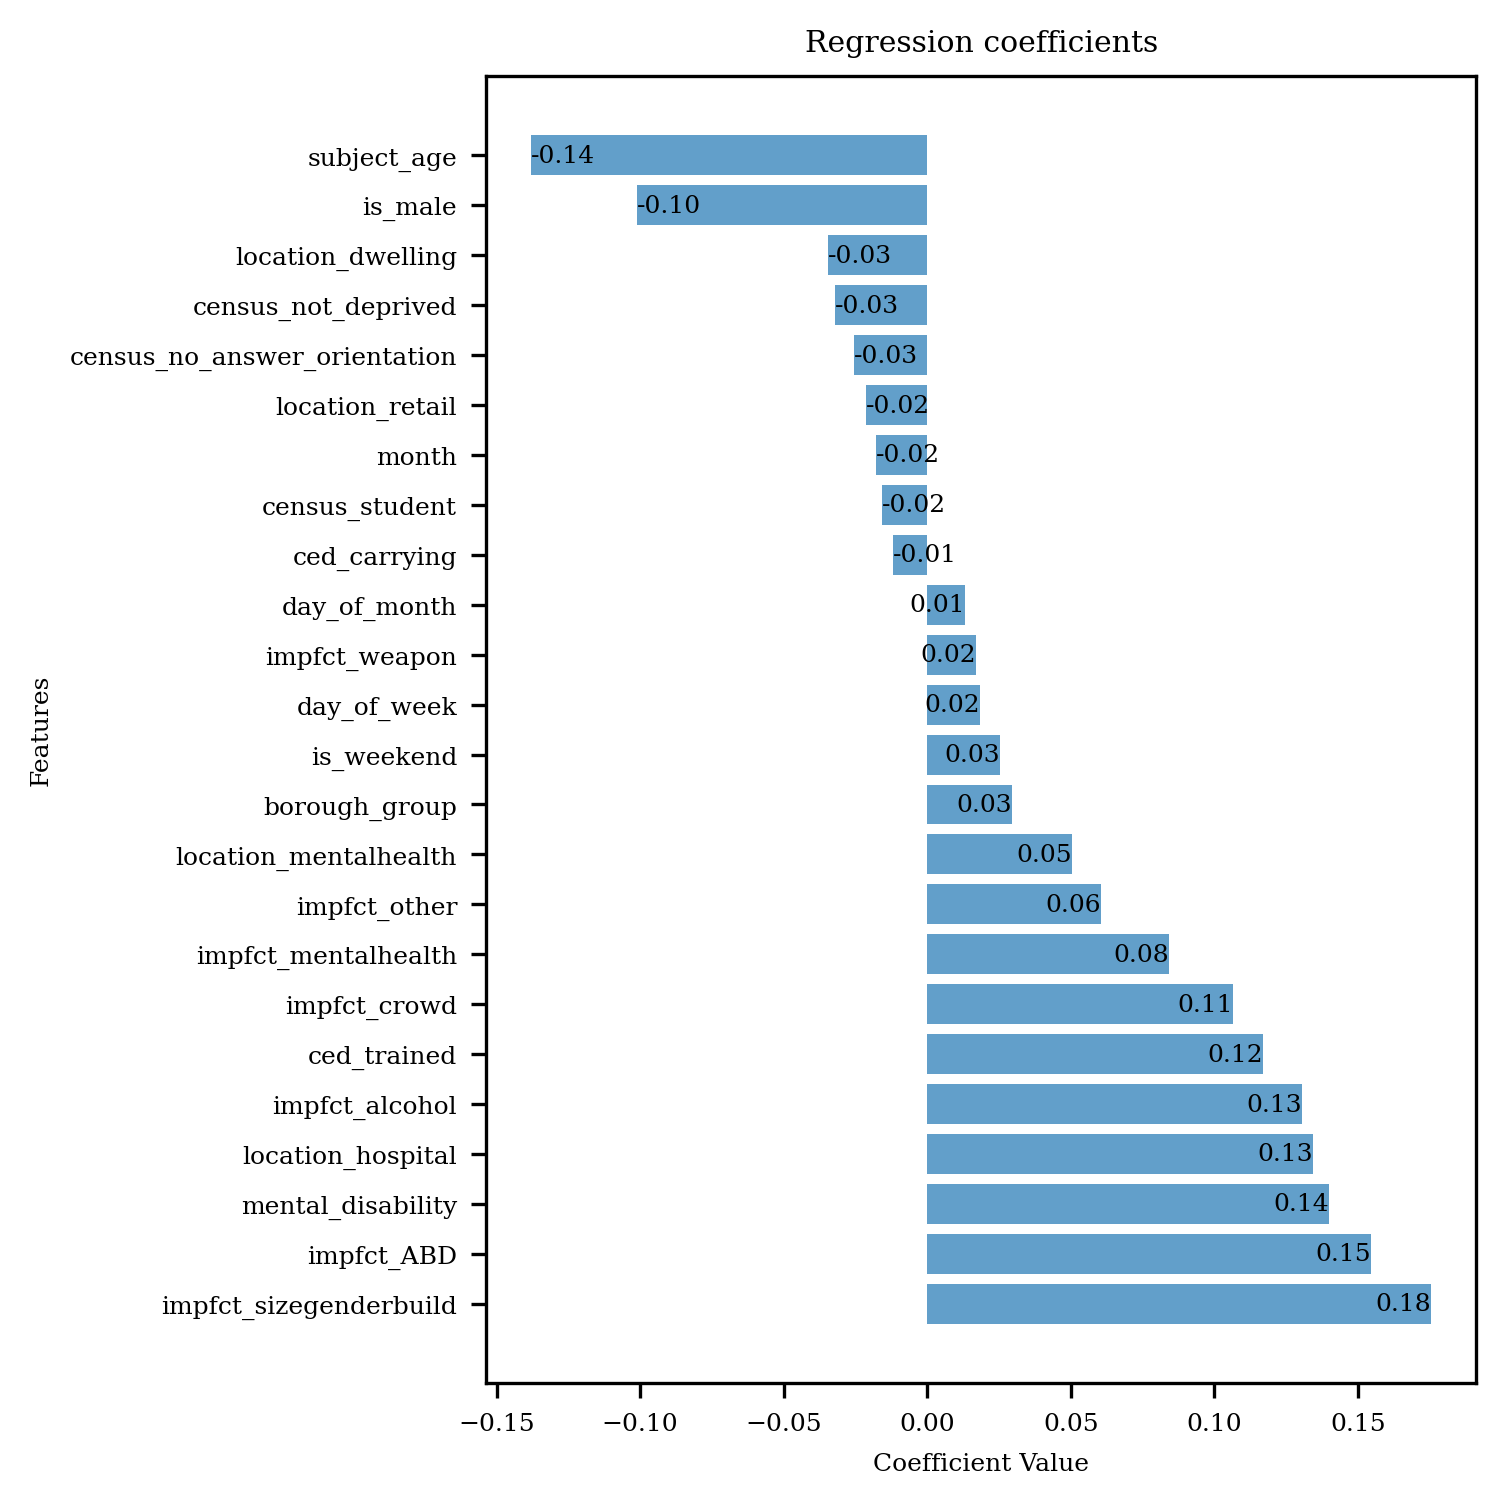

In [34]:
#display the normalized coefficients of the logistic regression model

coef = lr_model.coef_
non_zero_indices = np.where(np.abs(coef[2]) > 0.01)[0]  
filtered_coef = coef[2][non_zero_indices]
filtered_feature_names = np.array(feature_names)[non_zero_indices]

sorted_indices = np.argsort(-filtered_coef)
sorted_coef = filtered_coef[sorted_indices]
sorted_feature_names = filtered_feature_names[sorted_indices]

y_pos = np.arange(len(sorted_coef))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 6
plt.figure(figsize=(5, 5), dpi=300)
bars = plt.barh(y_pos, sorted_coef, align='center', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha='left' if width < 0 else 'right', va='center', color='black')

plt.yticks(y_pos, sorted_feature_names)
plt.ylabel('Features')
plt.xlabel('Coefficient Value')
plt.title('Regression coefficients')
plt.tight_layout()
plt.savefig('logreg_coefficients.png', dpi=300)
plt.show()

### Neural Network

In [40]:
#import the libraries necessary for deep learning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

#check the GPU availability
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
#scale the non-binary predictor variables using min-max scaling (binary variables are already scaled)
scaler = MinMaxScaler()
non_binary_columns = ['month',
 'day_of_month',
 'day_of_week',
 'hour_of_day',
 'subject_age',
 'census_not_deprived',
 'census_white_ethnic',
 'census_no_heating',
 'census_heterosexual',
 'census_gay_lesbian',
 'census_no_answer_orientation',
 'census_pop_density',
 'census_low_qualification',
 'census_high_qualification',
 'census_born_uk',
 'census_student',
 'mps_crime_rate'
 ]
X_train[non_binary_columns] = scaler.fit_transform(X_train[non_binary_columns])
X_test[non_binary_columns] = scaler.fit_transform(X_test[non_binary_columns])

In [37]:
#split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, stratify=y_train.values.reshape(-1, 1)
)

In [38]:
#one hot encoding for target variables
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

In [39]:
#define the neural network architecture
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=y_train_encoded.shape[1], activation='softmax')) 

In [32]:
#define the early stopping criteria (stop the training if validation loss doesnt improve for 20 consequtive epochs)
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
#define the model checkpoint to save the models after every training epoch
os.makedirs("checkpoints_RS2_NN", exist_ok=True)
checkpoint = ModelCheckpoint('checkpoints_RS2_NN/model_epoch_{epoch:02d}.h5', 
                                   monitor='val_loss', verbose=1, save_best_only=False, mode='min')

In [34]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics='accuracy')
#fit the model (saving the history of training)
history = model.fit(X_train, y_train_encoded, epochs=300, batch_size=128, 
                    validation_data=(X_val, y_val_encoded), verbose=1, 
                    callbacks=[earlystop, checkpoint])

Epoch 1/300
1282/1293 [============================>.] - ETA: 0s - loss: 2.6703 - accuracy: 0.3377
Epoch 1: saving model to checkpoints_RS2_NN\model_epoch_01.h5
1293/1293 [==============================] - 7s 5ms/step - loss: 2.6691 - accuracy: 0.3379 - val_loss: 2.5134 - val_accuracy: 0.3675
Epoch 2/300
1287/1293 [============================>.] - ETA: 0s - loss: 2.3771 - accuracy: 0.3695
Epoch 2: saving model to checkpoints_RS2_NN\model_epoch_02.h5
1293/1293 [==============================] - 6s 5ms/step - loss: 2.3766 - accuracy: 0.3696 - val_loss: 2.2421 - val_accuracy: 0.4181
Epoch 3/300
1286/1293 [============================>.] - ETA: 0s - loss: 2.1255 - accuracy: 0.4012
Epoch 3: saving model to checkpoints_RS2_NN\model_epoch_03.h5
1293/1293 [==============================] - 6s 5ms/step - loss: 2.1250 - accuracy: 0.4012 - val_loss: 2.0056 - val_accuracy: 0.4353
Epoch 4/300
1291/1293 [============================>.] - ETA: 0s - loss: 1.9078 - accuracy: 0.4214
Epoch 4: saving mod

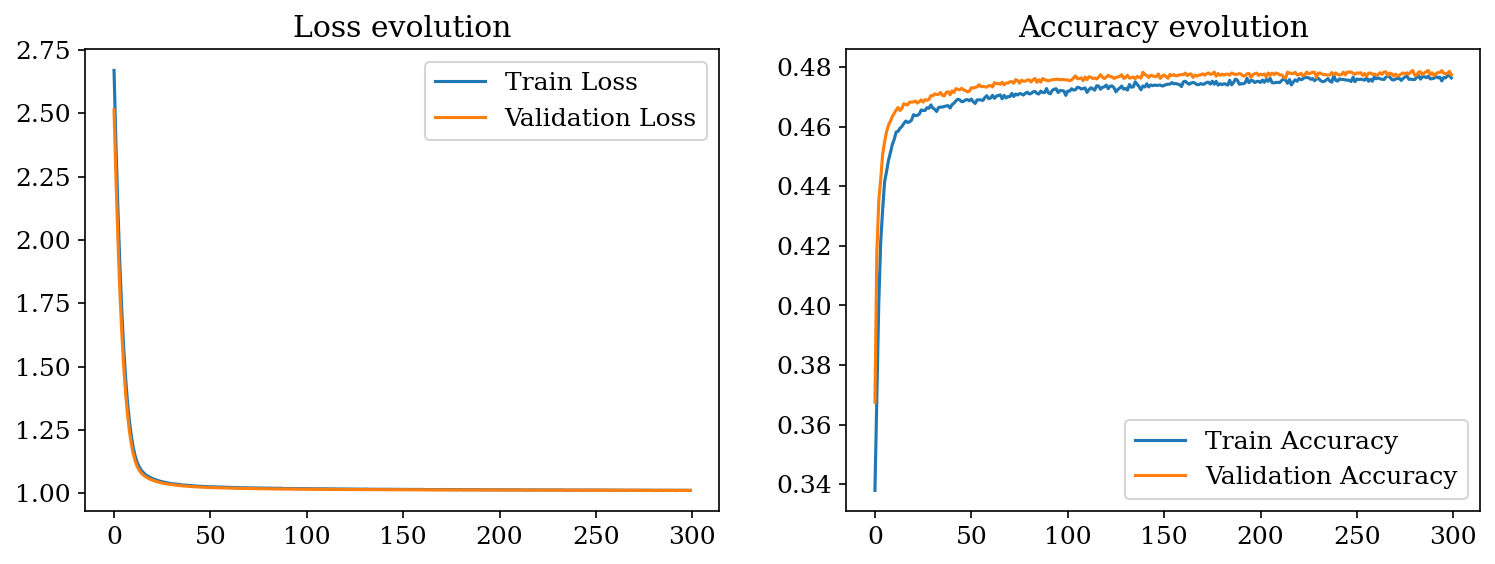

In [51]:
#plot the training history
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(12,4), dpi = 150)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.title('Accuracy evolution')

plt.show()

In [54]:
#display the epoch with the lowest validation loss
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Minimum validation loss of {min_val_loss} reached at epoch {min_val_loss_epoch}")

Minimum validation loss of 1.0109426975250244 reached at epoch 300


In [41]:
#load the model with the lowest validation loss
from tensorflow.keras.models import load_model
model = load_model('checkpoints_RS2_NN/model_epoch_300.h5')

In [42]:
#predict the class of the test set and display the accuracy
pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred)))

981/981 [==============================] - 3s 1ms/step
Accuracy: 0.5023101679253099


In [45]:
#insert the prediction values into the database

data_tuples = [(float(element[0]), float(element[1]), float(element[2])) for element in model.predict(X_test)]
cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
    CREATE TEMPORARY TABLE temp_table (
        id SERIAL PRIMARY KEY,
        nn_0 FLOAT,
        nn_1 FLOAT,
        nn_2 FLOAT
    )
""")
query = "INSERT INTO temp_table (nn_0, nn_1, nn_2) VALUES (%s, %s, %s);"
cursor.executemany(query, data_tuples)
cursor.execute("""
    UPDATE rq2_test_predictions 
    JOIN temp_table 
    ON rq2_test_predictions.id = temp_table.id
    SET 
        rq2_test_predictions.nn_0 = temp_table.nn_0, 
        rq2_test_predictions.nn_1 = temp_table.nn_1, 
        rq2_test_predictions.nn_2 = temp_table.nn_2
""")
db_connection.commit()

 24/981 [..............................] - ETA: 2s 

981/981 [==============================] - 1s 2ms/step
